In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, sys, time
import numpy as np
import pandas as pd
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' # Comment if not running on Colab

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))
from src.data_pipeline import prepare_data, create_dataloaders, data_dir, test_file
from src.model import CO2Transformer
from src.utils import seed_everything, get_device, rmse, save_scalers

model_dir = os.path.join('..', 'saved_models')
results_dir = os.path.join('..', 'results')
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

device = get_device()
print(f'Device: {device}')

Device: cuda


In [ ]:
print(model_dir)
print(results_dir)

../saved_models
../results


In [ ]:
# 1. Load data

In [ ]:
print('prepare_data() defaults:')
print(f'  data_dir:  {data_dir}')
print(f'  test_file: {test_file}')
print()

train_dfs, test_dfs, general_scaler, conc_scaler, feature_names = prepare_data()
save_scalers(general_scaler, conc_scaler)

print(f'Train files: {len(train_dfs)}, Test files: {len(test_dfs)}')
print(f'Features: {len(feature_names)}')
print(f'Train rows: {sum(len(df) for df in train_dfs)}')
print(f'Test rows:  {sum(len(df) for df in test_dfs)}')

prepare_data() defaults:
  data_dir:  /content/drive/MyDrive/Colab Notebooks/AI_CO2_paper/transformer_co2/data/withLabel
  test_file: 140207_1.xlsx

Train files: 7, Test files: 1
Features: 90
Train rows: 780
Test rows:  118


In [ ]:
# 2. Train function

In [ ]:
# Train function: d_model and n_head are chosen based on the best reduced dimension reported by the paper,
# e.g. DAE performed best using encoded dimension 16, LSTM performed best using 16 modes from POD  In aadition,
# dataset is relatively small, fewer parameters seems better.
def train_model(train_loader, val_loader, forecast_window,
                n_features=96, d_model=64, n_heads=4, n_layers=2, d_ff=128,
                lr=1e-3, weight_decay=1e-4, dropout=0.2,
                max_epochs=500, patience=50, seed=42,
                save_path=None, verbose=True):
    """Train CO2Transformer with early stopping on val loss. """

    seed_everything(seed)

    model = CO2Transformer(
        n_features=n_features, d_model=d_model, n_heads=n_heads,
        n_layers=n_layers, d_ff=d_ff, forecast_window=forecast_window,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=20
    ) # This scheduler might work ok on small datasets than other

    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    best_state = None
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()

        epoch_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = criterion(pred, y)

            optimizer.zero_grad()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # For gradient exploding, vanishing is dealt with residual etc.

            optimizer.step()

            epoch_loss += loss.item() * x.size(0)

        train_loss = epoch_loss / len(train_loader.dataset)

        # Validate
        model.eval()

        val_loss_sum = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                pred = model(x)
                val_loss_sum += criterion(pred, y).item() * x.size(0)

        val_loss = val_loss_sum / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1

        if verbose and (epoch % 50 == 0 or epoch == 1 or wait == 0):
            lr_now = optimizer.param_groups[0]['lr']
            marker = ' *' if wait == 0 else ''
            print(f'Epoch {epoch:3d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {lr_now:.1e}{marker}')

        if wait >= patience:
            if verbose:
                print(f'Early stopping at epoch {epoch} (patience={patience})')
            break

    # Restore best weights
    model.load_state_dict(best_state)
    model.to(device)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(best_state, save_path)

    if verbose:
        print(f'Best val loss: {best_val_loss:.6f}')

    return model, train_losses, val_losses

In [ ]:
# 3. Evaluation function

In [ ]:
def evaluate_model(model, test_loader, conc_scaler):
    """Evaluate on test set. Returns RMSE in real CO2 % (overall and per-point)."""
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            all_preds.append(pred)
            all_targets.append(y.numpy())

    preds = np.concatenate(all_preds, axis=0)    # (n, forecastWindow, 6)
    targets = np.concatenate(all_targets, axis=0)

    # Inverse transform: each column independently through conc_scaler
    n_samples, forecastWindow, n_points = preds.shape
    preds_flat = preds.reshape(-1, 1)
    targets_flat = targets.reshape(-1, 1)
    preds_real = conc_scaler.inverse_transform(preds_flat).reshape(n_samples, forecastWindow, n_points)
    targets_real = conc_scaler.inverse_transform(targets_flat).reshape(n_samples, forecastWindow, n_points)

    # Overall RMSE
    overall = rmse(preds_real, targets_real)

    # Per-point RMSE
    per_point = {}
    for p in range(6):
        per_point[f'Point {p+1}'] = rmse(preds_real[:, :, p], targets_real[:, :, p])

    return overall, per_point, preds_real, targets_real

In [ ]:
# 4. Train with one (inWindow, forecastWindow) pair

In [ ]:
# Quick test: inWindow=17, forecastWindow=1
inWindow, forecastWindow = 17, 1
train_loader, val_loader, test_loader = create_dataloaders(
    train_dfs, test_dfs, feature_names,
    input_window=inWindow, forecast_window=forecastWindow, batch_size=32
)

print(f'Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}')

model, train_losses, val_losses = train_model(
    train_loader, val_loader, forecast_window=forecastWindow,
    save_path=os.path.join(model_dir, f'model_iw{inWindow}_fw{forecastWindow}.pt')
)

Train: 528, Val: 133, Test: 101
Epoch   1 | train 0.070606 | val 0.011447 | lr 1.0e-03 *
Epoch   2 | train 0.009834 | val 0.008116 | lr 1.0e-03 *
Epoch   3 | train 0.008279 | val 0.007688 | lr 1.0e-03 *
Epoch   4 | train 0.008053 | val 0.006606 | lr 1.0e-03 *
Epoch   5 | train 0.006674 | val 0.004782 | lr 1.0e-03 *
Epoch   6 | train 0.004206 | val 0.003085 | lr 1.0e-03 *
Epoch   7 | train 0.003164 | val 0.002469 | lr 1.0e-03 *
Epoch   8 | train 0.002349 | val 0.001852 | lr 1.0e-03 *
Epoch   9 | train 0.002104 | val 0.001487 | lr 1.0e-03 *
Epoch  11 | train 0.001518 | val 0.000936 | lr 1.0e-03 *
Epoch  13 | train 0.001064 | val 0.000718 | lr 1.0e-03 *
Epoch  14 | train 0.000933 | val 0.000583 | lr 1.0e-03 *
Epoch  17 | train 0.000788 | val 0.000526 | lr 1.0e-03 *
Epoch  20 | train 0.000733 | val 0.000480 | lr 1.0e-03 *
Epoch  21 | train 0.000697 | val 0.000458 | lr 1.0e-03 *
Epoch  22 | train 0.000690 | val 0.000448 | lr 1.0e-03 *
Epoch  24 | train 0.000625 | val 0.000430 | lr 1.0e-03 *

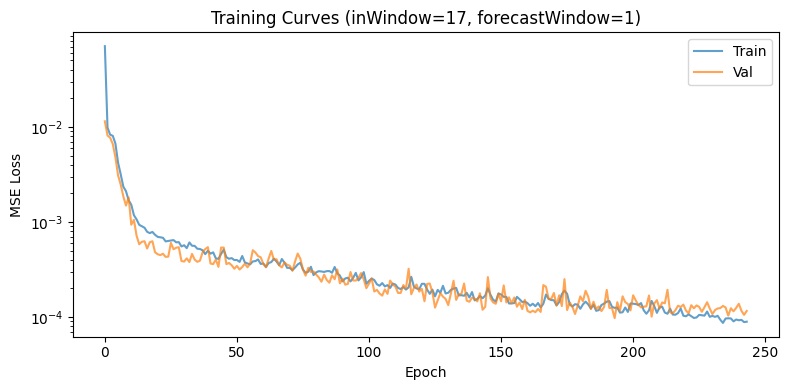

In [ ]:
# Training curves
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train_losses, label='Train', alpha=0.7)
ax.plot(val_losses, label='Val', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title(f'Training Curves (inWindow={inWindow}, forecastWindow={forecastWindow})')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
overall_rmse, per_point_rmse, preds_real, targets_real = evaluate_model(model, test_loader, conc_scaler)

print(f'Overall RMSE: {overall_rmse:.4f} CO2 %')
print(f'\nPer-point RMSE (CO2 %):')
for name, val in per_point_rmse.items():
    print(f'  {name}: {val:.4f}')

Overall RMSE: 0.1640 CO2 %

Per-point RMSE (CO2 %):
  Point 1: 0.0035
  Point 2: 0.0033
  Point 3: 0.0293
  Point 4: 0.0378
  Point 5: 0.1357
  Point 6: 0.3751


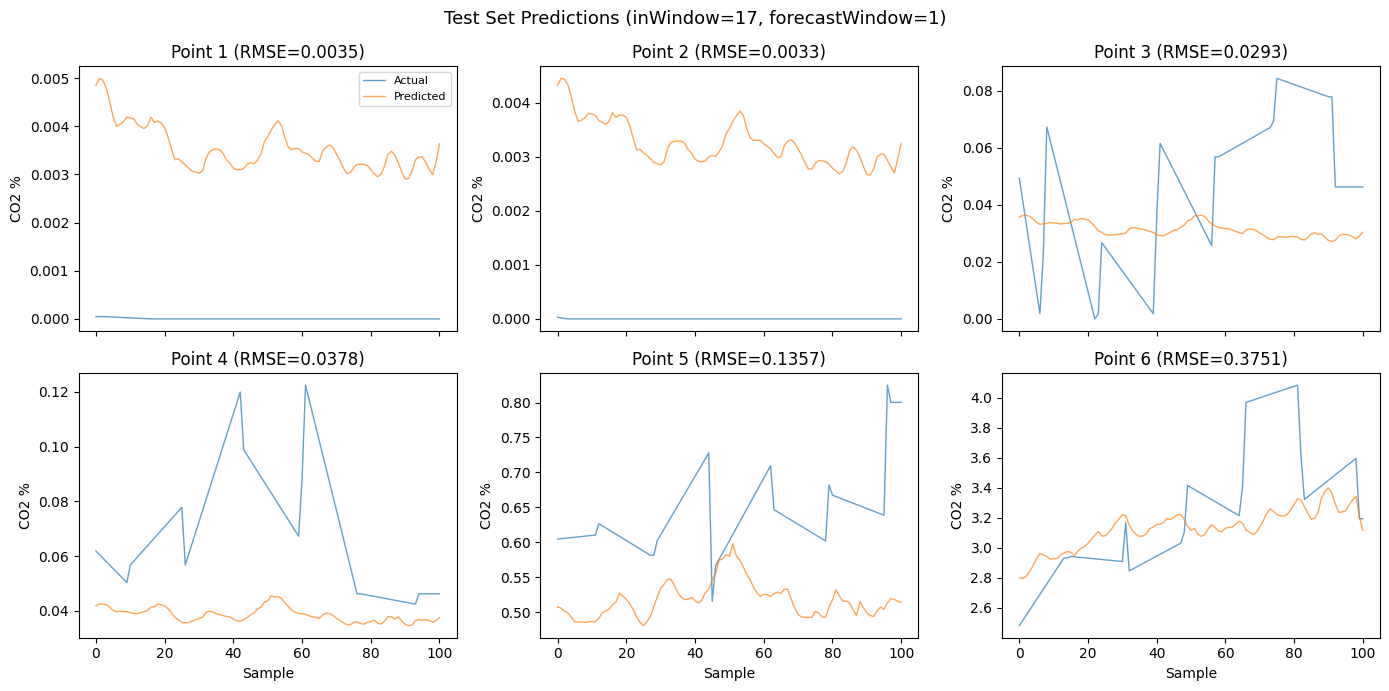

In [ ]:
# Prediction vs actual plot (forecastWindow=1: single-step forecast)
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True)
for p in range(6):
    ax = axes[p // 3, p % 3]
    ax.plot(targets_real[:, 0, p], label='Actual', alpha=0.7, linewidth=1)
    ax.plot(preds_real[:, 0, p], label='Predicted', alpha=0.7, linewidth=1)
    ax.set_title(f'Point {p+1} (RMSE={per_point_rmse[f"Point {p+1}"]:.4f})')
    ax.set_ylabel('CO2 %')
    if p >= 3:
        ax.set_xlabel('Sample')
    if p == 0:
        ax.legend(fontsize=8)
fig.suptitle(f'Test Set Predictions (inWindow={inWindow}, forecastWindow={forecastWindow})', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, f'predictions_iw{inWindow}_fw{forecastWindow}.png'), dpi=150)
plt.show()

In [ ]:
# 5. Grid search 12 different (inWindow, forecastWindow) pairs

In [ ]:
input_windows = [15, 17, 19]
forecast_windows = [1, 4, 8, 18]

results = []  # list of dicts

for inWindow in input_windows:
    for forecastWindow in forecast_windows:
        print(f'\n{"="*60}')
        print(f'Training: inWindow={inWindow}, forecastWindow={forecastWindow}')
        print(f'{"="*60}')

        seed_everything(42)
        train_loader, val_loader, test_loader = create_dataloaders(
            train_dfs, test_dfs, feature_names,
            input_window=inWindow, forecast_window=forecastWindow, batch_size=32
        )

        save_path = os.path.join(model_dir, f'model_iw{inWindow}_fw{forecastWindow}.pt')
        t0 = time.time()
        model, tl, vl = train_model(
            train_loader, val_loader, forecast_window=forecastWindow,
            save_path=save_path, verbose=True
        )
        elapsed = time.time() - t0

        overall, per_point, preds_real, targets_real = evaluate_model(
            model, test_loader, conc_scaler
        )

        # Save predictions
        np.save(os.path.join(results_dir, f'preds_iw{inWindow}_fw{forecastWindow}.npy'), preds_real)
        np.save(os.path.join(results_dir, f'targets_iw{inWindow}_fw{forecastWindow}.npy'), targets_real)

        row = {
            'input_window': inWindow,
            'forecast_window': forecastWindow,
            'overall_rmse': overall,
            'epochs': len(tl),
            'best_val_loss': min(vl),
            'time_sec': elapsed,
        }
        for name, val in per_point.items():
            row[name] = val
        results.append(row)

        print(f'RMSE: {overall:.4f} CO2 %, Epochs: {len(tl)}, Time: {elapsed:.1f}s')

print(f'\nDone. {len(results)} configurations trained.')


Training: inWindow=15, forecastWindow=1
Epoch   1 | train 0.068778 | val 0.011492 | lr 1.0e-03 *
Epoch   2 | train 0.010249 | val 0.008414 | lr 1.0e-03 *
Epoch   3 | train 0.008229 | val 0.007794 | lr 1.0e-03 *
Epoch   5 | train 0.006727 | val 0.004778 | lr 1.0e-03 *
Epoch   6 | train 0.004231 | val 0.003103 | lr 1.0e-03 *
Epoch   7 | train 0.002649 | val 0.001897 | lr 1.0e-03 *
Epoch   8 | train 0.002215 | val 0.001568 | lr 1.0e-03 *
Epoch   9 | train 0.001838 | val 0.001358 | lr 1.0e-03 *
Epoch  10 | train 0.001579 | val 0.001222 | lr 1.0e-03 *
Epoch  11 | train 0.001451 | val 0.000909 | lr 1.0e-03 *
Epoch  12 | train 0.001125 | val 0.000696 | lr 1.0e-03 *
Epoch  13 | train 0.001008 | val 0.000616 | lr 1.0e-03 *
Epoch  15 | train 0.000984 | val 0.000596 | lr 1.0e-03 *
Epoch  16 | train 0.000948 | val 0.000580 | lr 1.0e-03 *
Epoch  17 | train 0.000849 | val 0.000573 | lr 1.0e-03 *
Epoch  19 | train 0.000734 | val 0.000512 | lr 1.0e-03 *
Epoch  21 | train 0.000708 | val 0.000494 | lr 

In [ ]:
# 6. Results

In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(['input_window', 'forecast_window'])

# Display RMSE table
display_cols = ['input_window', 'forecast_window', 'overall_rmse',
                'Point 1', 'Point 2', 'Point 3', 'Point 4', 'Point 5', 'Point 6',
                'epochs', 'best_val_loss']
print(df_results[display_cols].to_string(index=False, float_format='%.4f'))

# Save
df_results.to_csv(os.path.join(results_dir, 'benchmark_results.csv'), index=False)
print(f'\nSaved to results/benchmark_results.csv')

 input_window  forecast_window  overall_rmse  Point 1  Point 2  Point 3  Point 4  Point 5  Point 6  epochs  best_val_loss
           15                1        0.1731   0.0040   0.0038   0.0282   0.0401   0.1587   0.3902     247         0.0001
           15                4        0.1927   0.0023   0.0038   0.0337   0.0466   0.1806   0.4321     318         0.0001
           15                8        0.1886   0.0016   0.0016   0.0351   0.0503   0.1718   0.4245     401         0.0001
           15               18        0.1778   0.0016   0.0016   0.0350   0.0501   0.1406   0.4077     432         0.0001
           17                1        0.1640   0.0035   0.0033   0.0293   0.0378   0.1357   0.3751     244         0.0001
           17                4        0.1890   0.0013   0.0023   0.0347   0.0475   0.2156   0.4055     337         0.0001
           17                8        0.1894   0.0031   0.0026   0.0328   0.0460   0.1855   0.4215     348         0.0001
           17           

In [ ]:
# Best configuration
best = df_results.loc[df_results['overall_rmse'].idxmin()]
print(f'Best configuration:')
print(f'  Input window:    {int(best["input_window"])}')
print(f'  Forecast window: {int(best["forecast_window"])}')
print(f'  Overall RMSE:    {best["overall_rmse"]:.4f} CO2 %')
print(f'  Epochs trained:  {int(best["epochs"])}')
print(f'\nPer-point RMSE:')
for p in range(1, 7):
    print(f'  Point {p}: {best[f"Point {p}"]:.4f}')

Best configuration:
  Input window:    19
  Forecast window: 18
  Overall RMSE:    0.1619 CO2 %
  Epochs trained:  500

Per-point RMSE:
  Point 1: 0.0016
  Point 2: 0.0017
  Point 3: 0.0319
  Point 4: 0.0485
  Point 5: 0.0914
  Point 6: 0.3814


In [ ]:
# 7. Best model predictions

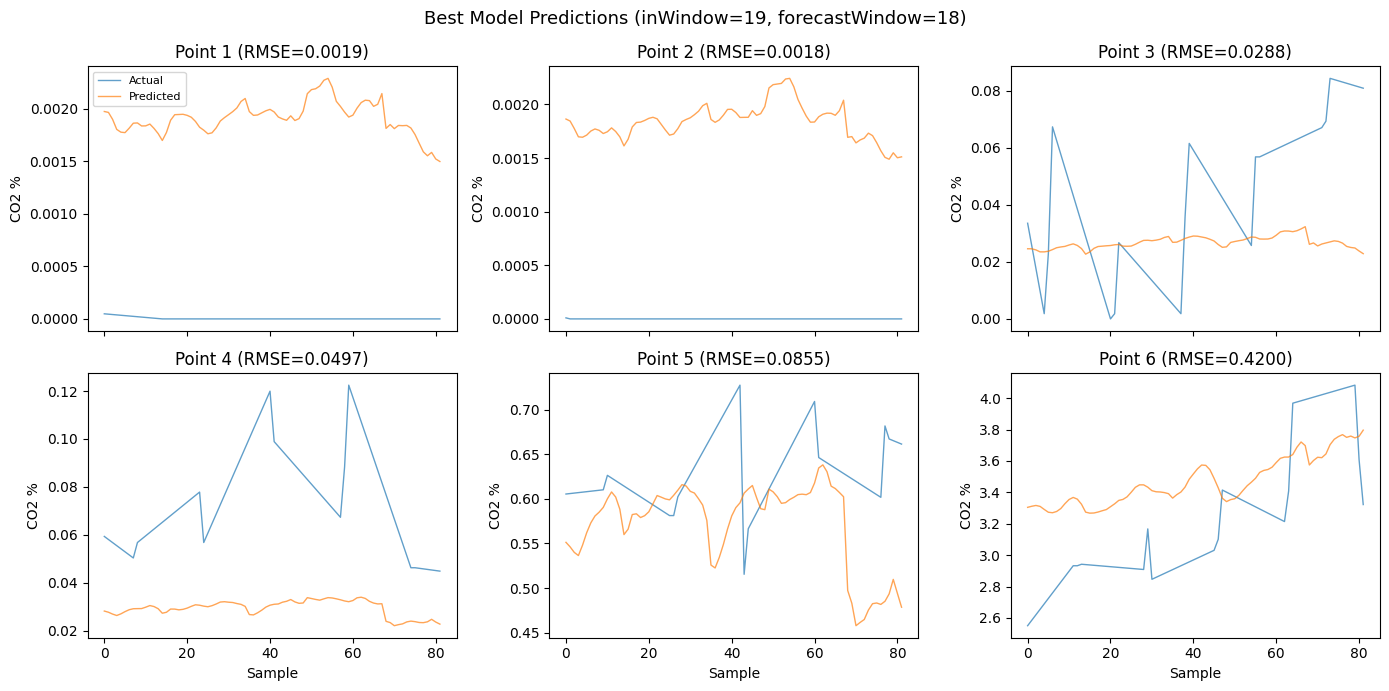

In [ ]:
# Load best model and plot
best_inWindow = int(best['input_window'])
best_forecastWindow = int(best['forecast_window'])

best_model = CO2Transformer(forecast_window=best_forecastWindow).to(device)
best_state = torch.load(
    os.path.join(model_dir, f'model_iw{best_inWindow}_fw{best_forecastWindow}.pt'),
    map_location=device, weights_only=True
)
best_model.load_state_dict(best_state)

_, _, test_loader_best = create_dataloaders(
    train_dfs, test_dfs, feature_names,
    input_window=best_inWindow, forecast_window=best_forecastWindow, batch_size=32
)

_, _, preds_best, targets_best = evaluate_model(best_model, test_loader_best, conc_scaler)

# Plot first forecast step for all 6 points
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True)
for p in range(6):
    ax = axes[p // 3, p % 3]
    ax.plot(targets_best[:, 0, p], label='Actual', alpha=0.7, linewidth=1)
    ax.plot(preds_best[:, 0, p], label='Predicted', alpha=0.7, linewidth=1)
    pt_rmse = rmse(preds_best[:, 0, p], targets_best[:, 0, p])
    ax.set_title(f'Point {p+1} (RMSE={pt_rmse:.4f})')
    ax.set_ylabel('CO2 %')
    if p >= 3:
        ax.set_xlabel('Sample')
    if p == 0:
        ax.legend(fontsize=8)
fig.suptitle(f'Best Model Predictions (inWindow={best_inWindow}, forecastWindow={best_forecastWindow})', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'best_model_predictions.png'), dpi=150)
plt.show()

In [ ]:
# 8. Baseline comparison (predict last known value).